In [1]:
import chainer
from PIL import Image, ImageDraw, ImageFont
import cv2
import numpy as np
import os
import matplotlib.pyplot as plt
import imutils
from imutils.contours import sort_contours

import sys
sys.path.append('../../')

from kr.detector.centernet.resnet import Res18UnetCenterNet
from kr.classifier.softmax.mobilenetv3 import MobileNetV3
from kr.datasets import KuzushijiUnicodeMapping

In [176]:
# unicode <-> unicode index mapping
mapping = KuzushijiUnicodeMapping()

# load trained detector
detector = Res18UnetCenterNet()
chainer.serializers.load_npz('/home/ec2-user/code/t-hanya/kuzushiji-recognition/results/detector/model_700.npz', detector)

# load trained classifier
classifier = MobileNetV3(out_ch=len(mapping))
chainer.serializers.load_npz('/home/ec2-user/code/t-hanya/kuzushiji-recognition/results/classifier/model_1000.npz', classifier)

# load image
image = Image.open('/home/ec2-user/code/restor-ai-tion/data/full/100241706/images/100241706_00002_2.jpg')

# character detection
bboxes, bbox_scores = detector.detect(image)

# character classification
unicode_indices, scores = classifier.classify(image, bboxes)
unicodes = [mapping.index_to_unicode(idx) for idx in unicode_indices]

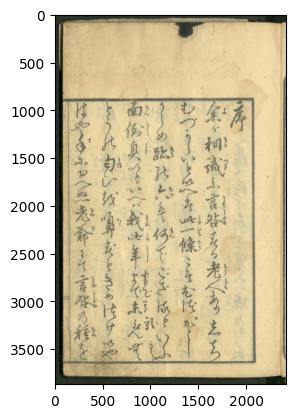

In [177]:
plt.imshow(image)
plt.show()

In [178]:
font_path = '/home/ec2-user/code/t-hanya/kuzushiji-recognition/data/font/NotoSansCJKjp-Regular.otf'
font = ImageFont.truetype(font_path, 120, encoding='utf-8')
text_color = 'rgb(255, 0, 0)'

def bbox_values(bbox):
    divisor = 1
    b = bbox/divisor
    return int(b[0]), int(b[1]), int(b[2]), int(b[3])

def visualize_preds(orig_filename, unicodes, unicode_scores, bboxes, bbox_scores, 
                    limit=-1,
                    verbose=False,
                    save=True,
                    save_folder='/home/ec2-user/code/t-hanya/kuzushiji-recognition/data/preds'):
    orig_img = Image.open(orig_filename)
    pred_img = Image.open(orig_filename)
    prev_draw = ImageDraw.Draw(pred_img)
    if limit == -1:
        limit = len(unicodes)
    for (pred, uscore, bbox, bscore) in zip(unicodes[:limit], unicode_scores[:limit], bboxes[:limit], bbox_scores[:limit]):
        x, y, w, h = bbox_values(bbox)
        i = np.argmax(pred)
        label = chr(int(pred[2:], 16))
        if verbose:
            print(pred, label, uscore, x, y, w, h, bscore)

        
        prev_draw.text((x + 150, y - 10), label, fill=text_color, font = font)

    plt.figure()
    plt.imshow(pred_img)
    plt.title('Predicted')
    if save:
        basename = os.path.basename(orig_filename)
        save_filename = os.path.join(save_folder, 'pred_{}'.format(basename))
        pred_img.save(save_filename)




U+3080 む 0.9372103 1319 2835 1465 2959 2.9132295
U+3081 め 0.9958371 521 2891 604 2989 2.8165984
U+3067 で 0.9995778 784 2844 901 2964 2.7846413
U+306E の 0.9997509 1040 1581 1183 1739 2.7033782
U+3092 を 0.99766326 494 1847 657 2004 2.6999097
U+3065 づ 0.996523 1332 2981 1477 3133 2.689744
U+3092 を 0.9997315 251 3428 338 3609 2.6753955
U+3072 ひ 0.94120675 491 1659 642 1805 2.6201873
U+3044 い 0.9999585 1052 3341 1187 3459 2.6010942
U+305A ず 0.99122286 520 2365 631 2546 2.541884
U+306B に 0.99510986 1583 1702 1717 1825 2.512259
U+4F8B 例 0.73106843 727 1127 917 1297 2.4980822
U+5E74 年 0.99994504 784 2408 887 2670 2.4934587
U+516D 六 0.9930397 1044 1782 1180 1940 2.483242
U+3075 ふ 0.99938047 1037 3468 1210 3609 2.4682765
U+3065 づ 0.99945575 1298 1088 1480 1196 2.4651842
U+4EBA 人 0.9818726 1566 2778 1776 2915 2.457151
U+306F は 0.8733992 1346 1888 1433 2063 2.4481187
U+306F は 0.99995947 1059 1962 1160 2173 2.384962
U+3044 い 0.9996443 1316 1480 1460 1541 2.3770175
U+805E 聞 0.19328861 473 2061 628 2

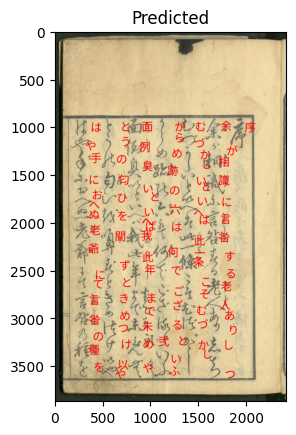

In [179]:
visualize_preds('/home/ec2-user/code/restor-ai-tion/data/full/100241706/images/100241706_00002_2.jpg',
                unicodes, scores, bboxes, bbox_scores, limit=-1, verbose=True, save=True)

In [180]:
' '.join([chr(int(c[2:], 16)) for c in unicodes])

'む め で の を づ を ひ い ず に 例 年 六 ふ づ 人 は は い 聞 と い の け や む る ご の 面 ざ 未 き い 此 へ て つ 我 匂 爺 此 に 相 識 そ 何 跡 め し 老 言 手 や と 余 条 は 咎 か 臭 咎 め い 言 が 一 と 老 り と る お こ か ば う ま す ぬ か へ 以 あ に し へ ら や で 種 と 序 つ し へ 弐'

In [181]:
def get_text(chars, boxes, limit=-1):
    if limit == -1:
        limit = len(chars)

    ubox_tuples = [(chr(int(c[2:], 16)), bbox_values(box)) for (c, box) in zip(chars[:limit], boxes[:limit])]
    print(ubox_tuples)

In [182]:
get_text(unicodes, bboxes, limit=10)

[('む', (1319, 2835, 1465, 2959)), ('め', (521, 2891, 604, 2989)), ('で', (784, 2844, 901, 2964)), ('の', (1040, 1581, 1183, 1739)), ('を', (494, 1847, 657, 2004)), ('づ', (1332, 2981, 1477, 3133)), ('を', (251, 3428, 338, 3609)), ('ひ', (491, 1659, 642, 1805)), ('い', (1052, 3341, 1187, 3459)), ('ず', (520, 2365, 631, 2546))]


In [183]:
int_boxes = np.array([bbox_values(b) for b in bboxes[:10]])
print(int_boxes)

[[1319 2835 1465 2959]
 [ 521 2891  604 2989]
 [ 784 2844  901 2964]
 [1040 1581 1183 1739]
 [ 494 1847  657 2004]
 [1332 2981 1477 3133]
 [ 251 3428  338 3609]
 [ 491 1659  642 1805]
 [1052 3341 1187 3459]
 [ 520 2365  631 2546]]


In [184]:
def bbox_values2(bbox):
    divisor = 1
    b = bbox/divisor
    return int(b[0]), int(b[1]), int(abs(b[0]-b[2])), int(abs(b[1]-b[3]))

def get_unicode(uc):
    return [chr(int(c[2:],16)) for c in uc]

scaled_bboxes = [bbox_values2(b) for b in bboxes]



print(scaled_bboxes[:10])
print(' '.join(get_unicode(unicodes)))


# uc = [chr(int(c[2:], 16)) for c in unicodes]
# tb = list(zip(*sorted(zip(uc, scaled_bboxes), key=lambda b: -b[1][0]+b[1][1], reverse=False)))
# print(' '.join(list(tb)[0]))
# for i in range(10):
#     print(tb[0][i], tb[1][i])
# # rl = list(zip(*sorted(zip(*tb), key=lambda b: b[1][1], reverse=False)))
# # print(' '.join(list(rl)[0]))
# # print(rl[0][0], tb[1][0])
# # print(rl[0][1], rl[1][1])

# arr = np.array(bboxes)
# r = (arr[:, 0]**2 + arr[:, 1] **2)**0.5
# indices = np.argsort(r)
# print(indices)
# ordered_chars = []
# for i in indices:
#     c = unicodes[i]
#     ordered_chars.append(chr(int(c[2:], 16)))
# print(ordered_chars)



[(1319, 2835, 145, 123), (521, 2891, 82, 97), (784, 2844, 116, 119), (1040, 1581, 143, 157), (494, 1847, 162, 156), (1332, 2981, 144, 152), (251, 3428, 87, 181), (491, 1659, 150, 146), (1052, 3341, 134, 118), (520, 2365, 110, 181)]
む め で の を づ を ひ い ず に 例 年 六 ふ づ 人 は は い 聞 と い の け や む る ご の 面 ざ 未 き い 此 へ て つ 我 匂 爺 此 に 相 識 そ 何 跡 め し 老 言 手 や と 余 条 は 咎 か 臭 咎 め い 言 が 一 と 老 り と る お こ か ば う ま す ぬ か へ 以 あ に し へ ら や で 種 と 序 つ し へ 弐


In [185]:
img = cv2.imread('/home/ec2-user/code/restor-ai-tion/data/full/100241706/images/100241706_00002_2.jpg', cv2.IMREAD_GRAYSCALE)
blurred = cv2.GaussianBlur(img, [5, 5], 0)
edged = cv2.Canny(blurred, 30, 150)
cnts = cv2.findContours(edged.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
cnts = imutils.grab_contours(cnts)
cnts[:2]
# cv2.boundingRect(cnts[0])
# cnts = imutils.contours.sort_contours(cnts, method='left-to-right')[0]
# print(cnts[:1])

(array([[[ 132, 3837]],
 
        [[ 131, 3838]],
 
        [[ 131, 3839]],
 
        [[ 130, 3840]],
 
        [[ 130, 3841]],
 
        [[ 129, 3842]],
 
        [[ 129, 3843]],
 
        [[ 128, 3844]],
 
        [[ 128, 3849]],
 
        [[ 129, 3849]],
 
        [[ 130, 3850]],
 
        [[ 130, 3848]],
 
        [[ 131, 3847]],
 
        [[ 131, 3845]],
 
        [[ 132, 3844]],
 
        [[ 132, 3843]],
 
        [[ 133, 3842]],
 
        [[ 133, 3841]],
 
        [[ 134, 3840]],
 
        [[ 135, 3840]],
 
        [[ 135, 3838]],
 
        [[ 134, 3837]]], dtype=int32),
 array([[[ 143, 3830]],
 
        [[ 142, 3831]],
 
        [[ 141, 3831]],
 
        [[ 140, 3832]],
 
        [[ 141, 3831]],
 
        [[ 143, 3831]],
 
        [[ 144, 3830]],
 
        [[ 145, 3831]],
 
        [[ 145, 3832]],
 
        [[ 143, 3834]],
 
        [[ 140, 3834]],
 
        [[ 143, 3834]],
 
        [[ 144, 3833]],
 
        [[ 145, 3833]],
 
        [[ 146, 3832]],
 
        [[ 145, 3831]],
 

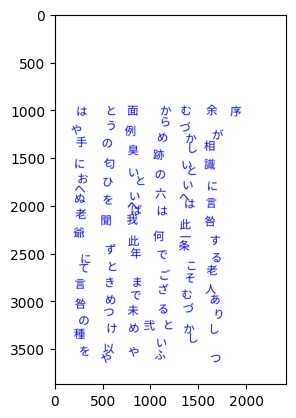

In [186]:
# new image attempt.
filename = '/home/ec2-user/code/restor-ai-tion/data/full/100241706/images/100241706_00002_2.jpg'
tgt_folder = '/home/ec2-user/code/t-hanya/kuzushiji-recognition/data/preds'
tgt_filename = os.path.join(tgt_folder, 'ocr_{}'.format(os.path.basename(filename)))
cv2img = cv2.imread('/home/ec2-user/code/restor-ai-tion/data/full/100241706/images/100241706_00002_2.jpg')
n, m = cv2img.shape[0], cv2img.shape[1]
pred_image = Image.new('RGB', (m, n), color=(255,255,255,127))
pred_draw = ImageDraw.Draw(pred_image)
limit = len(unicodes)
for (pred, bbox) in zip(unicodes[:limit], bboxes[:limit]):
    x, y, w, h = bbox_values(bbox)
    i = np.argmax(pred)
    label = chr(int(pred[2:], 16))
    pred_draw.text((x, y), label, fill=text_color, font = font)
pred_image.save(tgt_filename)    

ocr_img = cv2.imread(tgt_filename)
plt.imshow(ocr_img)

In [ ]:
bboxes

In [207]:
## easyocr on modern japenese
import easyocr
reader = easyocr.Reader(['ja'])
result = reader.readtext(tgt_filename, detail = 0)
print(result)

['は', 'と 面', '苔む 余 序', 'う', 'の', '例', 'え樹', '臭', 'に', '句', '比', '識', 'ひ', 'に', 'の', 'い', 'に', 'を', '六', 'へ', '言', '聞', '', 'は', '答', '節', '何', '英', 'す', 'ず', 'で', 'そ', '言', 'き', 'ま', 'ぎ', 'む', '当茉', 'る', 'づ', '鷺', 'け め弐 と', 'を ぶ や', '芋', '跡', '豊', '', '君', 'そ', '命', 'ブ と', 'い']


In [208]:
' '.join(result)

'は と 面 苔む 余 序 う の 例 え樹 臭 に 句 比 識 ひ に の い に を 六 へ 言 聞  は 答 節 何 英 す ず で そ 言 き ま ぎ む 当茉 る づ 鷺 け め弐 と を ぶ や 芋 跡 豊  君 そ 命 ブ と い'

In [209]:
# manga-ocr
from manga_ocr import MangaOcr

mocr = MangaOcr()
text = mocr(tgt_filename)

2023-10-07 05:13:18.706 | INFO     | manga_ocr.ocr:__init__:13 - Loading OCR model from kha-white/manga-ocr-base


/home/ec2-user/venv/lib/python3.10/site-packages/transformers/models/vit/feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(


2023-10-07 05:13:23.832 | INFO     | manga_ocr.ocr:__init__:19 - Using CUDA
2023-10-07 05:13:25.137 | INFO     | manga_ocr.ocr:__init__:32 - OCR ready


In [210]:
print(text)

ま、自由車に乗車するようにしっかりしつむつ、近い住宅を、そもうもしない方が多いのでは何でしょう。いか期間遅いと思っていたと思いますが、というのです。どうのか、すけどこので、何か。何かを期した。


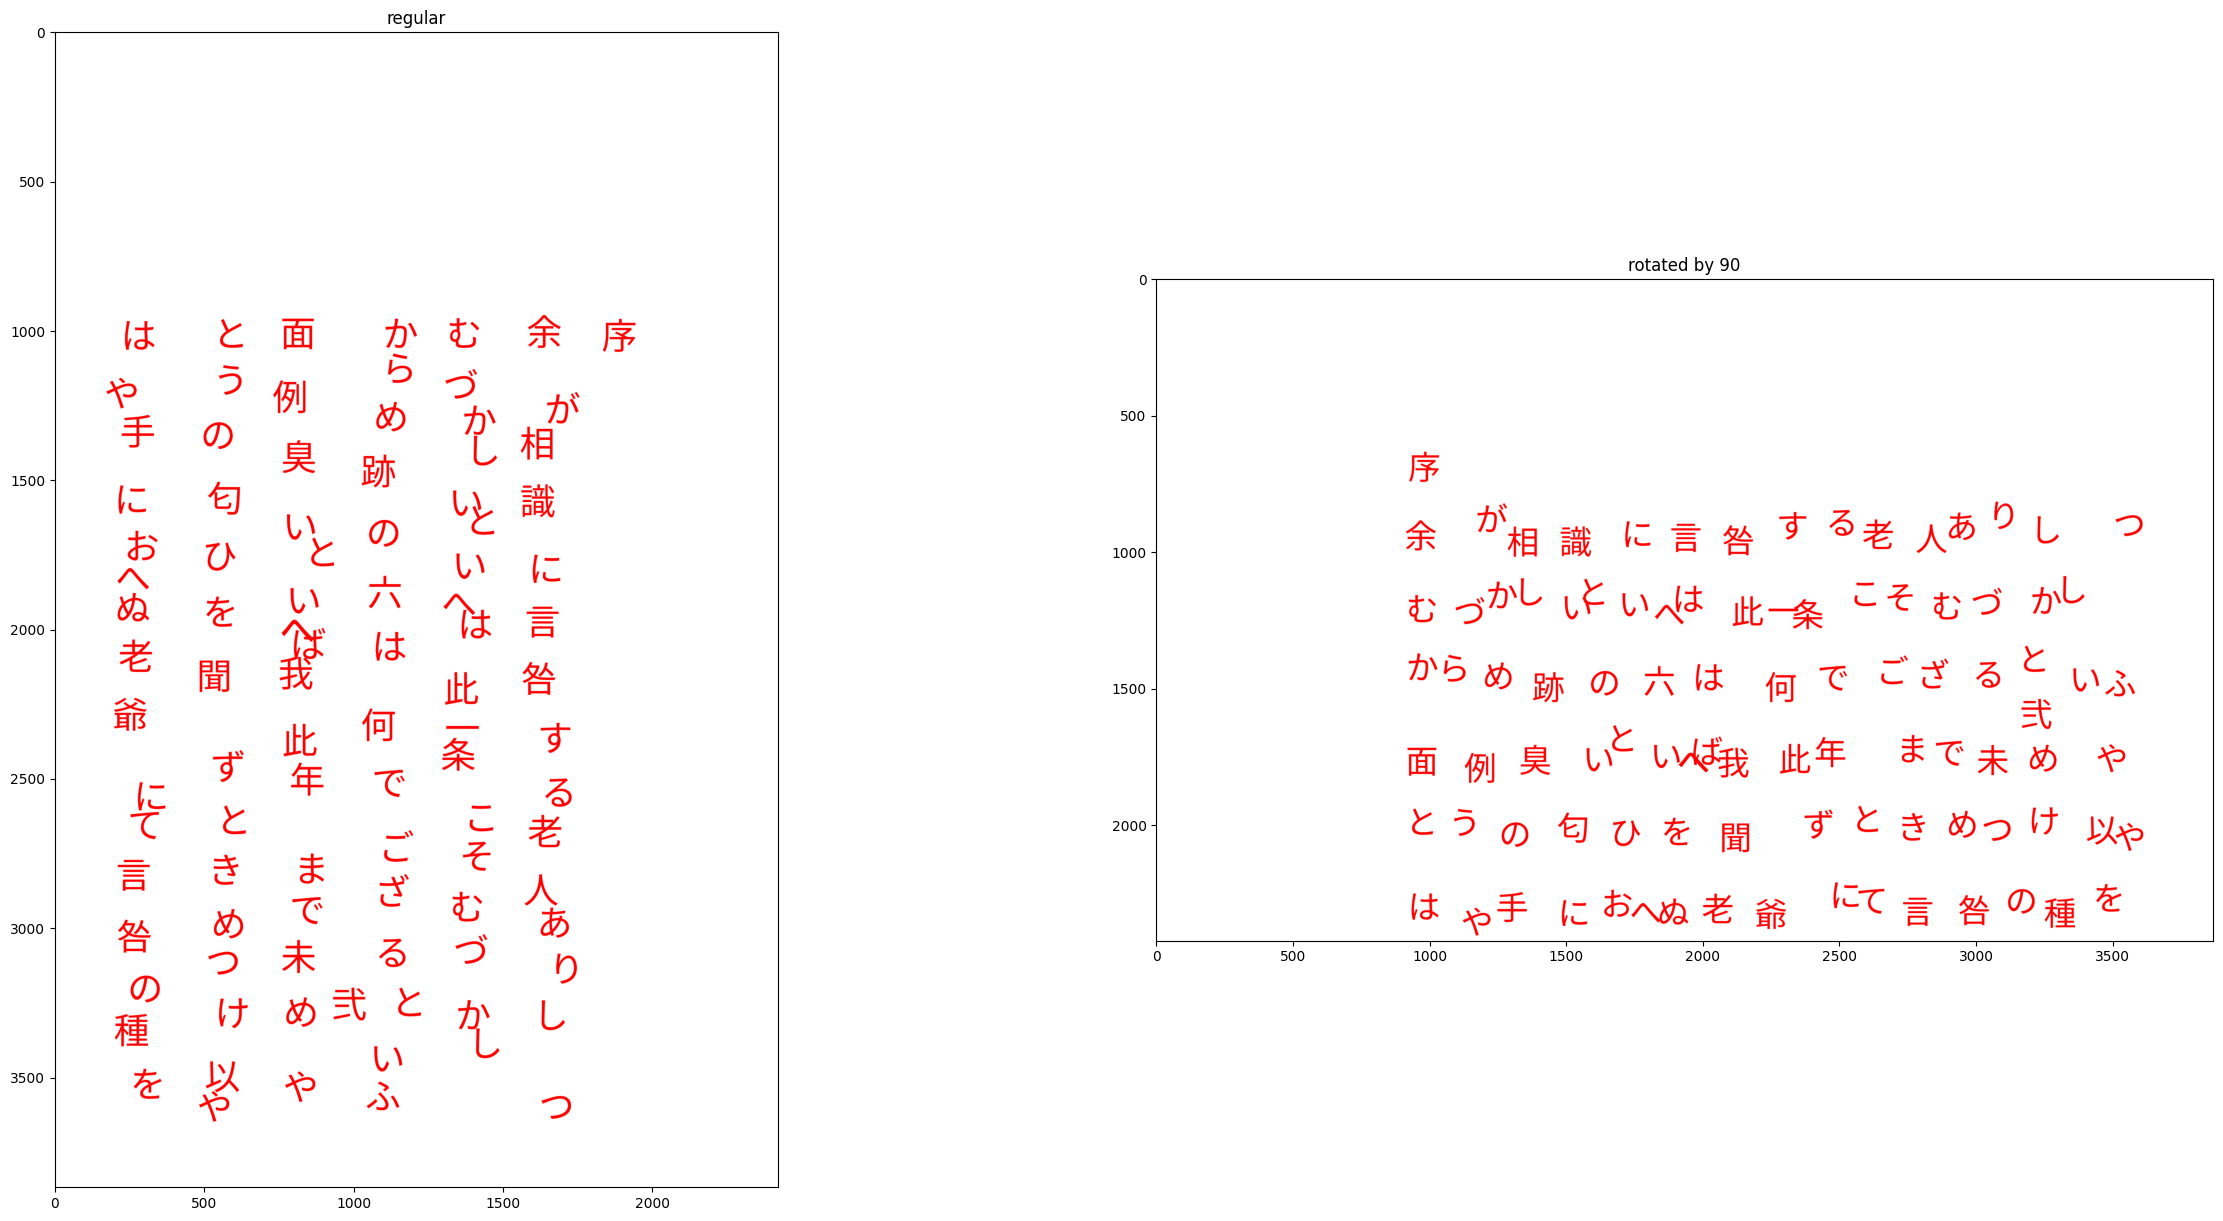

In [234]:
# new image (rotated) attempt.

from scipy.ndimage import rotate

filename = '/home/ec2-user/code/restor-ai-tion/data/full/100241706/images/100241706_00002_2.jpg'
tgt_folder = '/home/ec2-user/code/t-hanya/kuzushiji-recognition/data/preds'
tgt_filename = os.path.join(tgt_folder, 'ocr_{}'.format(os.path.basename(filename)))
tgt_rot_filename = os.path.join(tgt_folder, 'ocr_rotated_{}'.format(os.path.basename(filename)))
cv2img = cv2.imread('/home/ec2-user/code/restor-ai-tion/data/full/100241706/images/100241706_00002_2.jpg')
n, m = cv2img.shape[0], cv2img.shape[1]
pred_rot_image = Image.new('RGB', (n, m), color=(255,255,255,127))
pred_image = Image.new('RGB', (m, n), color=(255,255,255,127))

def rot(dim_orig, dim_rot, xy, angle=90):
    org_center = (np.array(dim_orig[:2][::-1])-1)/2.
    rot_center = (np.array(dim_rot[:2][::-1])-1)/2.
    org = xy-org_center
    a = np.deg2rad(angle)
    new = np.array([org[0]*np.cos(a) + org[1]*np.sin(a),
            -org[0]*np.sin(a) + org[1]*np.cos(a) ])
    return new+rot_center

pred_draw = ImageDraw.Draw(pred_image)
pred_rot_draw = ImageDraw.Draw(pred_rot_image)
limit = len(unicodes)
for (pred, bbox) in zip(unicodes[:limit], bboxes[:limit]):
    x, y, w, h = bbox_values(bbox)
    xr, yr = rot((n, m), (m, n), (x,y))
    # print(x, y, xr, yr)
    i = np.argmax(pred)
    label = chr(int(pred[2:], 16))
    pred_rot_draw.text((xr, yr), label, fill=text_color, font = font)
    pred_draw.text((x, y), label, fill=text_color, font=font)

plt.figure(figsize=(30,15))
plt.subplot(1,2,1)
plt.imshow(pred_image)
plt.title('regular')

plt.subplot(1,2,2)
plt.imshow(pred_rot_image)
plt.title('rotated by 90')
plt.show()

pred_image.save(tgt_filename)
pred_rot_image.save(tgt_rot_filename)    

# ocr_img = cv2.imread(tgt_rot_filename)


In [235]:
reader = easyocr.Reader(['ja'])
result = reader.readtext(tgt_rot_filename, detail = 0)
' '.join(result)

'序 余 が相 識 に言答する老 人ありし つ む しいへ 此-条 こそむづ から め 跡 の六は 何で ござ 弐 面 例臭 いと まで未め や とうの句ひを 間 ず とき めっけ は におへぬ 老 翁 言 名の種 を かし づかし ると いふ 此年 いば我 以や にて や手'